In [48]:
import os
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import gc

In [49]:
class IndianDrivingDataset(Dataset):

    def __init__(self, img_dir):

        self.img_dir = img_dir
        self.img_list = []
        for i in os.listdir(self.img_dir):
            file_path = os.path.join(img_dir, i)
            self.img_list.append(file_path)

    def __len__(self):

        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):

        img_path= self.img_list[idx]
        img = Image.open(img_path)
        img = np.array(img)
        nimg = img[:,0:256,:]

        img = Image.open(img_path).convert('L')
        img = np.array(img)
        nlabel = img[:,256:]
        img_tensor = torch.from_numpy(np.array(nimg))
        img_tensor = img_tensor.permute(2, 0, 1)            
        img_tensor = img_tensor.type(torch.float32) / 255.0

        return img_tensor, nlabel

In [50]:
data = IndianDrivingDataset('archive/train')
print(len(data))

2975


In [51]:
train_size = int(0.04* len(data))
test_size = len(data) - train_size

train_set, test_set = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=8)
test_loader = DataLoader(test_set, batch_size=2, shuffle=False, num_workers=8)

print(len(train_set),len(test_set))

119 2856


In [52]:
import network

model = network.modeling.__dict__['deeplabv3plus_mobilenet'](num_classes=19, output_stride=8)
model.load_state_dict( torch.load('best_deeplabv3plus_mobilenet_cityscapes_os16.pth', map_location='cpu')['model_state'])

<All keys matched successfully>

In [53]:
id_dict = {'road':0, 'sidewalk':1, 'building':2, 'wall':3, 'fence':4, 'pole':5, 'traffic light':6, 'traffic sign':7, 'vegetation':8, 'terrain':9, 'sky':10, 'person':11, 'rider':12, 'car':13,
           'truck':14, 'bus':15, 'train':16, 'motorcycle':17, 'bicycle':18, 'unlabelled': 255}

class_dict = {}

for i in id_dict:
    class_dict[id_dict[i]] = i
# this on what mobilenet model was trained on.

# converted_dict = {0:0, 1:0, 2:1, 3:9, 4:11, 5:12, 6:17, 7:18, 8:13, 9:13, 10:14, 11:15, 12:15, 13:3, 14:3, 15:4, 16:4, 17:7, 18:7, 19:6, 20:5, 21:5, 22:2, 23:2, 24:8, 25:10, 255:255}

In [54]:
def calculate_mAP(seg_gt, seg_pred, num_classes=19):
    list_precision = []
    list_recall = []

    avg_precision = 0.0
    for class_id in range(num_classes):
        class_gt = (seg_gt == class_id).astype(np.float32)
        class_pred = (seg_pred == class_id).astype(np.float32)

        true_positives = np.sum(class_gt * class_pred)
        false_positives = np.sum(class_pred) - true_positives
        false_negatives = np.sum(class_gt) - true_positives

        precision = true_positives / (true_positives + false_positives + 1e-8)
        recall = true_positives / (true_positives + false_negatives + 1e-8)
        list_precision.append(precision)
        list_recall.append(recall)

        avg_precision += precision

    mAP = avg_precision / num_classes
    return mAP, list_precision, list_recall

def calculate_mIoU(seg_gt, seg_pred, num_classes=19):
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)
    for class_id in range(num_classes):
        class_gt = (seg_gt == class_id).astype(np.float32)
        class_pred = (seg_pred == class_id).astype(np.float32)

        intersection[class_id] = np.sum(class_gt * class_pred)
        union[class_id] = np.sum(class_gt) + np.sum(class_pred) - intersection[class_id]

    IoU = intersection / (union + 1e-8)
    mIoU = np.mean(IoU)
    return IoU

In [55]:
num_counter = 0
pixel_accuracy = 0
dice_coeff = 0
total_mAP = 0

total_mIoU = {}
total_precision = {}
total_recall = {}
for i in range(19):
    total_mIoU[i] = (0,0)
    total_precision[i] = (0,0)
    total_recall[i] = (0,0)

In [56]:
def visualise(pred, label):
    plt.figure(figsize=(16,12))

    plt.subplot(1,2,1)
    im = plt.imshow(pred)
    plt.axis('off')

    plt.subplot(1,2,2)
    im = plt.imshow(label)
    plt.axis('off')

    plt.show()
    

In [57]:
def metric_func(pred, label, flag=False):
    global num_counter, pixel_accuracy, dice_coeff, total_mIoU, total_mAP, total_precision, total_recall
    num_counter+=1
    pixel_wise_accuracy = np.mean(pred == label)
    intersection = np.sum(pred * label)
    union = np.sum(pred) + np.sum(label)
    dice_coefficient = (2.0 * intersection) / union
    mAP, precision, recall = calculate_mAP(label,pred)
    mIoU = calculate_mIoU(label,pred)
    if(flag):
        print(mIoU)
    if(flag):
        visualise(pred, label)
    for i, j in enumerate(mIoU):
        if j!=0:
            a, b = total_mIoU[i]
            a+=j
            b+=1
            total_mIoU[i] = (a,b)
    pixel_accuracy += pixel_wise_accuracy
    dice_coeff += dice_coefficient
    total_mAP += mAP
    for i, j in enumerate(precision):
        if j!=0:
            a, b = total_precision[i]
            a+=j
            b+=1
            total_precision[i] = (a,b)
    for i, j in enumerate(recall):
        if j!=0:
            a, b = total_recall[i]
            a+=j
            b+=1
            total_recall[i] = (a,b)

[0.03959072 0.         0.         0.         0.         0.
 0.         0.         0.00502625 0.00056593 0.00864625 0.0033389
 0.         0.04504505 0.         0.         0.         0.
 0.        ]


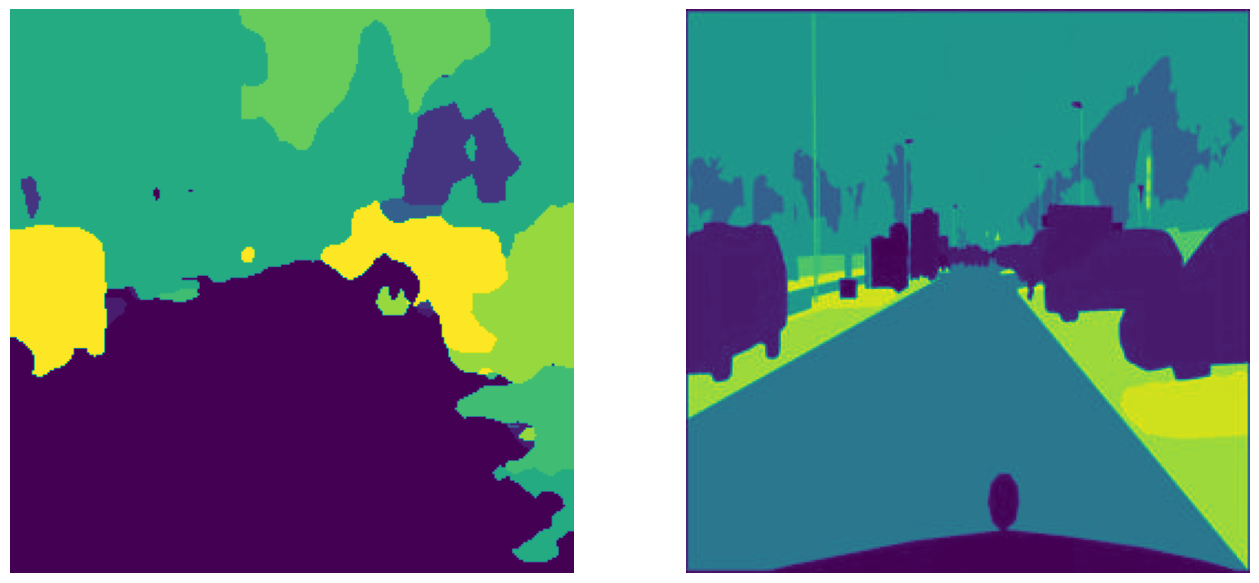

[0.11156046 0.         0.00550041 0.         0.         0.00609756
 0.         0.00980392 0.00228311 0.         0.0005005  0.01360544
 0.         0.00090978 0.         0.         0.04437932 0.
 0.04472843]


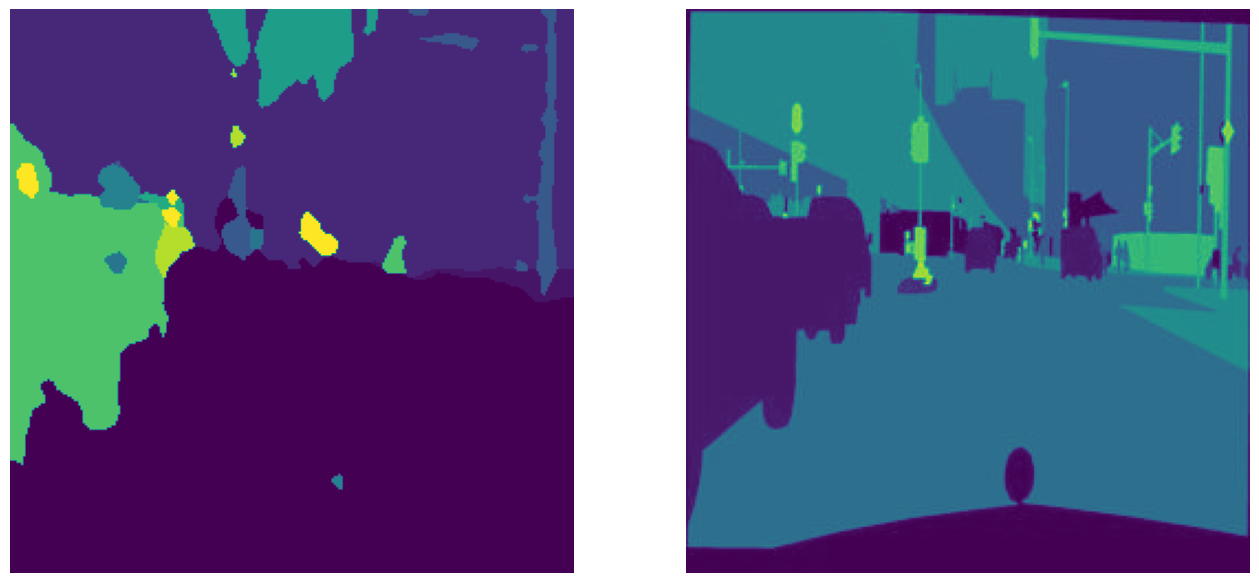

[0.04242024 0.         0.00428443 0.         0.         0.
 0.         0.         0.00296754 0.         0.         0.
 0.         0.00433839 0.         0.         0.         0.
 0.        ]


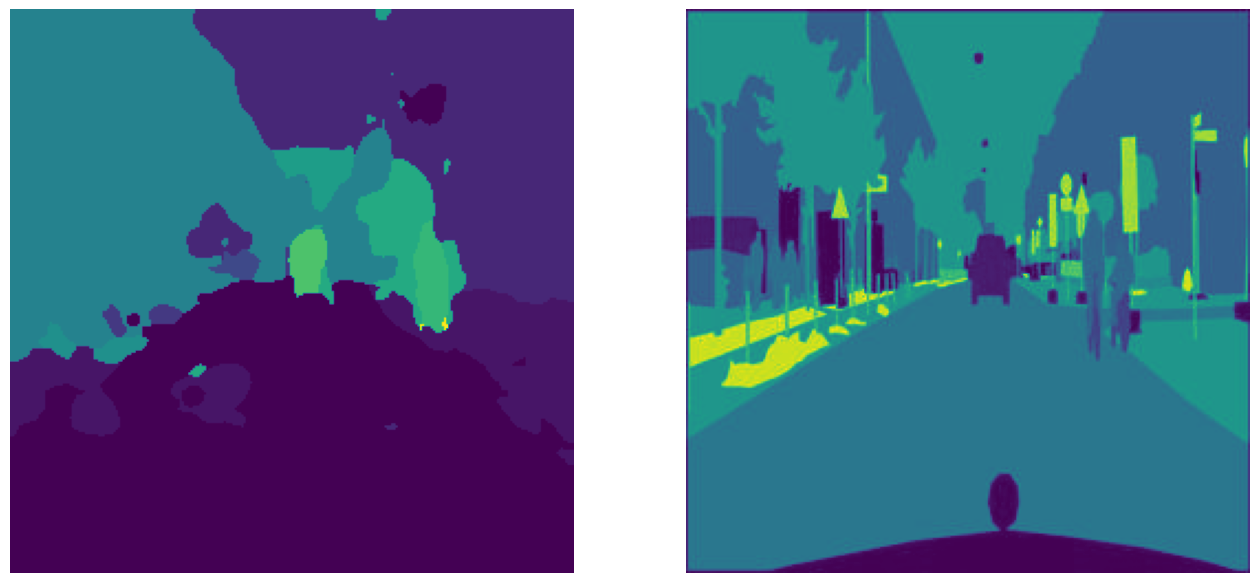

[0.03266782 0.         0.0061657  0.         0.         0.
 0.         0.         0.0011474  0.         0.00447307 0.
 0.         0.00289675 0.         0.         0.         0.
 0.0017301 ]


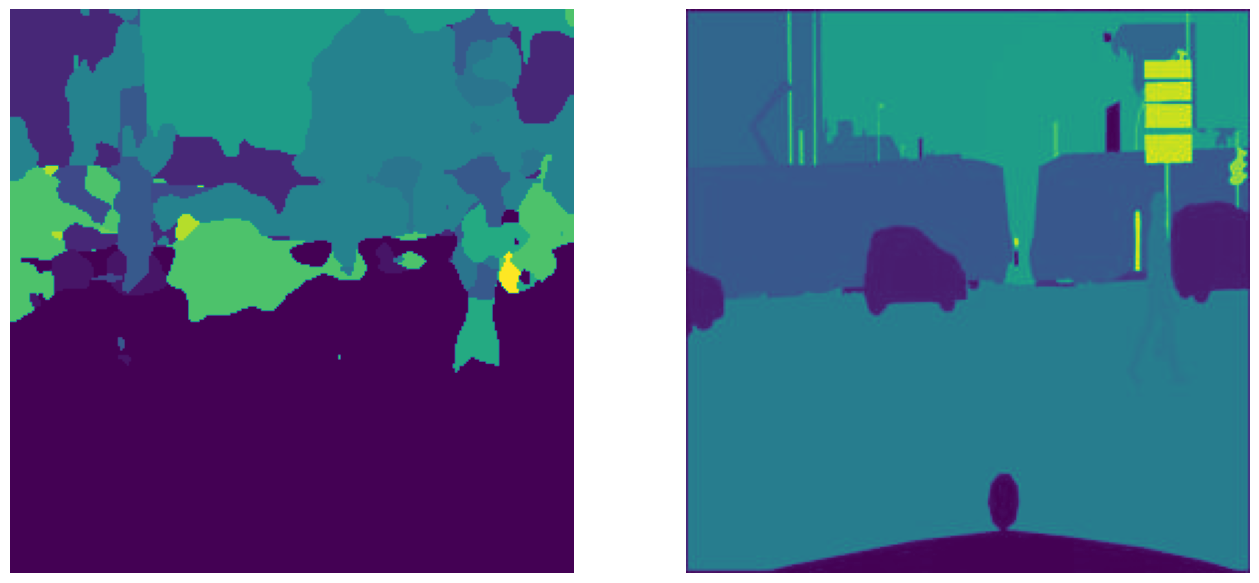

[0.11232841 0.         0.00344468 0.         0.00261643 0.00094697
 0.         0.         0.00188722 0.         0.00181159 0.
 0.         0.00054905 0.         0.         0.         0.
 0.        ]


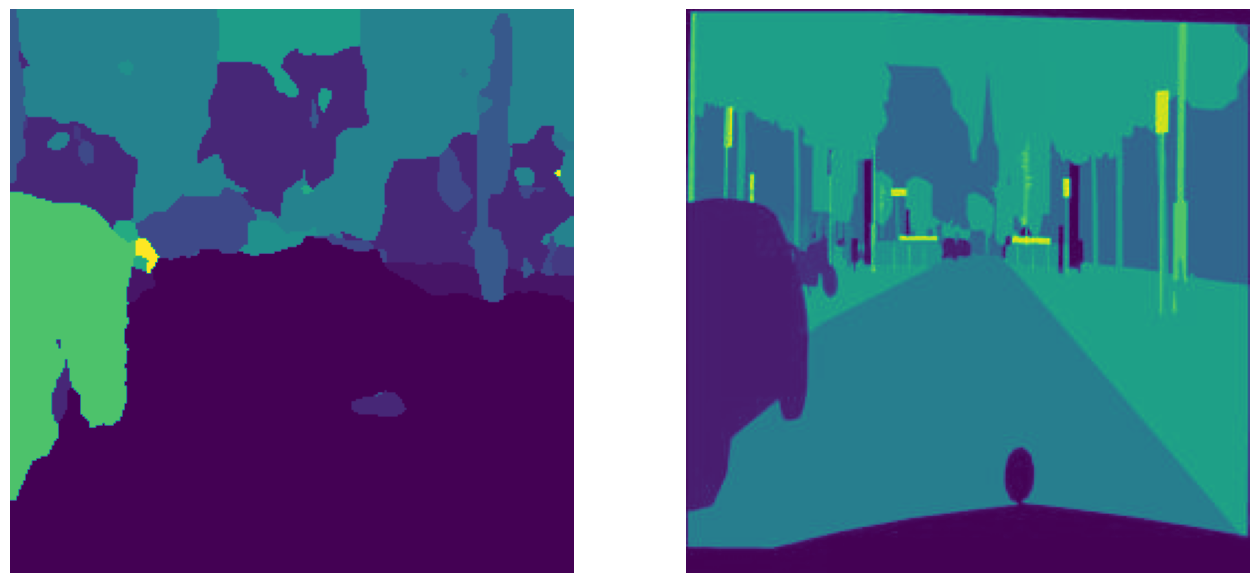

[0.04249576 0.         0.         0.         0.         0.
 0.         0.         0.00363169 0.         0.00149566 0.
 0.         0.00931278 0.         0.         0.         0.
 0.        ]


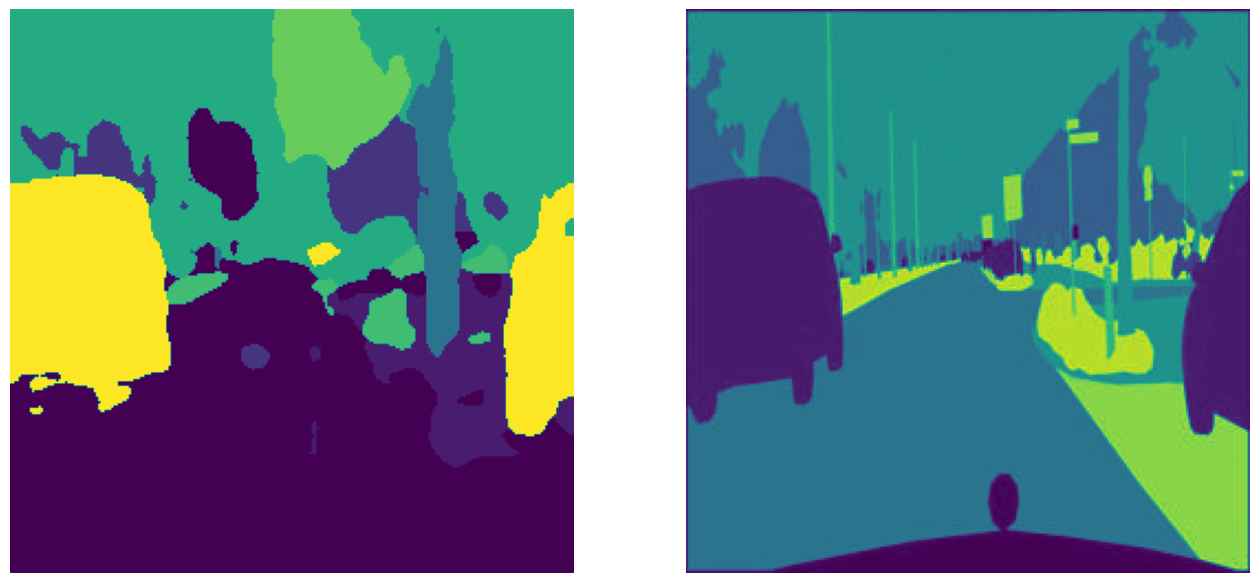

In [58]:
y_pred = []
y_true = []

for image, label in test_loader:
    flag = False
    if(num_counter>=100):
        break
    with torch.no_grad():
        outputs = model(image)
    preds = outputs.max(1)[1].detach().numpy()
    labels = label.numpy()
    if(num_counter<6):
        flag = True
    metric_func(preds[0],labels[0],flag)
    metric_func(preds[1],labels[1],flag)
    y_pred.append(preds[0])
    y_true.append(labels[0])
    y_pred.append(preds[1])
    y_true.append(labels[1])
    del image, labels, outputs
    gc.collect()

In [59]:
print('Performance')

print('Pixel Wise Accuracy: ', pixel_accuracy/num_counter*100)
print('Dice Coefficient Accuracy: ', dice_coeff/num_counter)
print('mAP', total_mAP/num_counter*100)


Performance
Pixel Wise Accuracy:  3.2895660400390625
Dice Coefficient Accuracy:  6.536267641178236
mAP 1.010700333782504


In [60]:
print('Performance Class Wise for 100 images')
for i in range(19):
    if(i!=19):
        print(class_dict[i])
    else:
        print('Unlabelled')
    a, b = total_mIoU[i]
    if(b==0):
        print("mIoU:",'nan')
    else:
        print("mIoU:", a/b*100)

    a, b = total_recall[i]
    if(b==0):
        print("Recall:",'nan')
    else:
        print("Recall:", a/b*100)

    a, b = total_precision[i]
    if(b==0):
        print("Precision:",'nan')
    else:
        print("Precision:", a/b*100)

Performance Class Wise for 100 images
road
mIoU: 6.874417873185578
Recall: 88.9473757878868
Precision: 6.952073673125536
sidewalk
mIoU: 0.49246391565719966
Recall: 2.99557675420721
Precision: 0.703704635136757
building
mIoU: 0.8391092161722862
Recall: 19.249960664528025
Precision: 0.8864378653482105
wall
mIoU: 0.9980467592018937
Recall: 1.9931918317904047
Precision: 2.646383806780951
fence
mIoU: 0.8170459597107786
Recall: 3.1067019008549583
Precision: 1.5296361460611025
pole
mIoU: 0.5675113967089987
Recall: 5.056991956701105
Precision: 0.6746415665082325
traffic light
mIoU: 0.8684435640455415
Recall: 1.5321014769546522
Precision: 4.850806385417463
traffic sign
mIoU: 0.7991547380346588
Recall: 4.018981223816534
Precision: 1.3624811154663907
vegetation
mIoU: 0.3032758604376099
Recall: 25.95761647959924
Precision: 0.33454403649013803
terrain
mIoU: 0.4299775467759858
Recall: 3.3244094168314113
Precision: 0.6977639059503725
sky
mIoU: 0.3994118886938288
Recall: 11.678787757191913
Precision: 

I have done for 10 images, because for images where masks are not changing the color there is some class mismatch for the rest of the images
Where things are going well. The objects are occluded they are many classes together and hence it is not able to distinguish between the closer classes
whereas there is no perfect boundary or match of colors. Also environment sometimes hinder with the main object

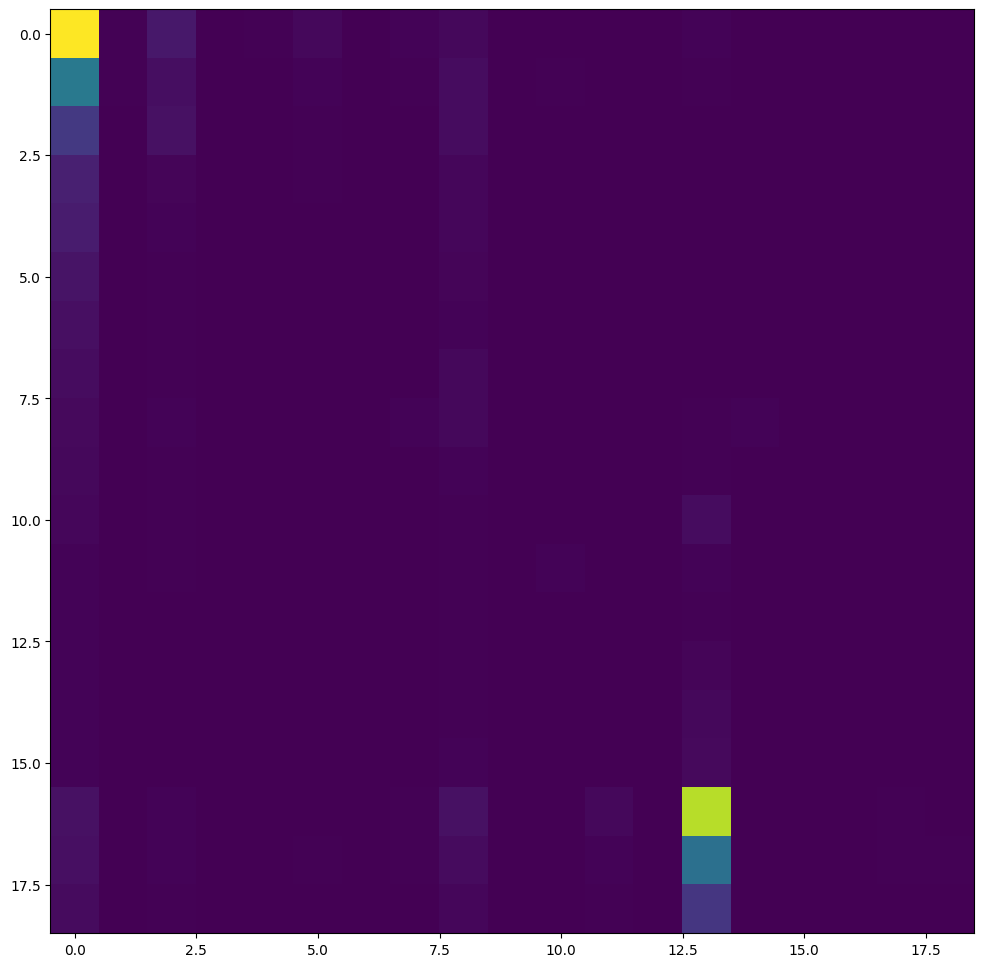

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(16,12))
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
cm = confusion_matrix(y_true, y_pred, labels=range(19))
plt.imshow(cm, cmap='viridis')
plt.show(plt)

The confusion matrix as heatmap shows the good understading of the road class. There is a little heats for class vegetation, sky, and car based on their diagnol color understading well amount of class. For other blue patches outside of the diagnols there is confusion. Some of it is based on the model efficiency while some of it is due to the
change of labels I have manually done in order to change the number of class from 26 to 19. As the mobile net is trained on 19 classes.

When can also see the same analysis of results from the precision, recall and F1 score of different classes. We can see classes road, vegetation, sky, car are very well classified which we can see from the printed results as well. For classes bicycle, traffic light and terrain we can train on the IDD for better results. Please refer to the performance metrics above for each class.

Image quality, camera version, the domain all are very different in CityScapes and IDD. All this the dataset is very differnt given proper roads in europe whereas muddy area in india. Performing very bad on cityscape as well because very low resoluion image in comparision to the orginal training images

Not proper training for these classes because underfitting plus no proper demarkation. Hence worst performance in these classes